# Feature Extraction from Unstructured Ob Notes 

In [48]:
import os, sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import glob

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from IPython.core.display import display, HTML    
display(HTML("<style>.container {width:90% !important; }</style>"))
%matplotlib inline 
np.set_printoptions(precision=5, suppress=True) 

In [3]:
root_path="/dors/capra_lab/users/"
# root_path="/Volumes/"

In [8]:
sys.path.append( "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification")
# os.chdir("/Volumes/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/")
from hyperparam_tune import initialize, create_held_out,validate_best_model
from train_test_rf import load_labels

# Functions

In [9]:
def replace_empty(value_list): 
    if len(value_list) == 0: 
        new_value = None 
    else: 
        new_value = value_list[0]
        
        return new_value

In [10]:
def parse_concepts_txt(concepts_dir):
    rows_list = []
    
    file_list = glob.glob(concepts_dir+"/*.txt")
    
    for index, concept_file in enumerate(file_list): 
        print("on {} out of {}".format(index, len(file_list)))
        with open(concept_file, 'r') as fh: 
            grid = os.path.basename(concept_file).split("-")[0]        

            for line in fh: 
                if (line.find('assertion=present') > -1) and line.startswith('NamedEntity'): 
                    _type, _pos1, _pos2 = line.split("\t")[:3]


                    assertion =  [x.split("=")[1].rstrip()  for x in line.split("\t") if (x.find('assertion')>-1)] 
                    semantic  =  [x.split("=")[1].rstrip()  for x in line.split("\t") if (x.find('semantic')>-1)] 
                    cui  =  [x.split("=")[1].rstrip()  for x in line.split("\t") if (x.find('cui')>-1)] 
                    ne  =  [x.split("=")[1].rstrip()  for x in line.split("\t") if (x.find('ne')>-1)] 

                    rows_list.append({'grid': grid,
                                       'type':_type,
                                       'pos_in_txt1': _pos1, 
                                       'pos_in_txt2': _pos2,
                                       'assertion': replace_empty(assertion),
                                       'semantic': replace_empty(semantic),
                                       'cui': replace_empty(cui),
                                       'ne': replace_empty(ne)})

    concepts_df = pd.DataFrame(rows_list)

    return concepts_df 

# Load Data 

In [11]:
CONCEPTS_DIR=os.path.join(root_path, "abraha1/projects/PTB_phenotyping/data/ptb_predict_machine_learning/ob_notes_variables/unstructured/notes_txt_clamp/")
RAW_TXT_DIR=os.path.join(root_path, "abraha1/projects/PTB_phenotyping/data/ptb_predict_machine_learning/ob_notes_variables/unstructured/notes_txt/")
KEY_FILE=os.path.join(root_path, "abraha1/projects/PTB_phenotyping/data/ptb_predict_machine_learning/ob_notes_variables/unstructured/key_icd9_10_grids.txt_Attributes.LD-2.tsv")

DELIVERY_LABELS_FILE = os.path.join(root_path, "abraha1/projects/PTB_phenotyping/data/combined_cohorts_07_12_2018/full_dataset_characterization/est_delivery_date_at_least_one_icd_cpt_ega.tsv")
EGA_FILE="/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/data/combined_cohorts_07_12_2018/full_dataset_characterization/expanded_ega/date_of_concep_from_closest_ega_within_20wks_of_delivery.tsv"

FEAT_OUTPUT_DIR ="/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/data/ptb_predict_machine_learning/feature_matrices/ob_notes_unstruct/since_concep_upto_28_weeks"

## Load delivery labels

In [13]:
final_labels_df = load_labels(DELIVERY_LABELS_FILE)


Loading delivery labels...
	0 out of 39008
	5000 out of 39008
	10000 out of 39008
	15000 out of 39008
	20000 out of 39008
	25000 out of 39008
	30000 out of 39008
	35000 out of 39008
	Created delivery-type labels df with shape:36379,3


In [14]:
# load EGA data  -- keep only first/earliest delivery
ega_df = pd.read_csv(EGA_FILE, sep="\t")
ega_df.delivery_date = pd.to_datetime(ega_df.delivery_date)
ega_df.sort_values(['GRID','delivery_date'],inplace=True, ascending=True)
earliest_ega_df = ega_df[~ega_df.duplicated(['GRID'], keep='first')].copy()

# check that earliest EGA delivery identified refers to teh earliest delivery in the delivery labels dataset
# keep only ega values for delivery date matching in final_labels_df
temp_first_label_df = final_labels_df.copy()
temp_first_label_df['GRID_DDATE'] = temp_first_label_df.GRID +"_"+temp_first_label_df.delivery_date

temp_early_ega_df = earliest_ega_df.copy()
temp_early_ega_df['GRID_DDATE'] = temp_early_ega_df.GRID +"_"+ temp_early_ega_df.delivery_date.dt.strftime( "%Y-%m-%d")

# align delivery dates
keep_early_ega_df = temp_early_ega_df[temp_early_ega_df.GRID_DDATE.isin(temp_first_label_df.GRID_DDATE)].copy()


# GRIDS with delivery label but w/o a corresponding EGA
final_labels_df[~final_labels_df.GRID.isin(keep_early_ega_df.GRID)].shape


final_dates_dict = dict(zip(keep_early_ega_df.GRID, keep_early_ega_df.delivery_date.astype('str')))
final_labels_dict =  dict(zip(final_labels_df.GRID, final_labels_df.label))
preg_start_date_dict = dict(zip(keep_early_ega_df.GRID, keep_early_ega_df.date_of_conception.astype('str')))



(10907, 3)

In [19]:
# check for duplicate GRIDS
print("number of duplicated grids in delivery label df: {}".format(final_labels_df[final_labels_df.duplicated(subset="GRID")].shape[0]))

number of duplicated grids in delivery label df: 0


## Load concepts

In [16]:
concepts_df = parse_concepts_txt(CONCEPTS_DIR)

on 0 out of 2434
on 1 out of 2434
on 2 out of 2434
on 3 out of 2434
on 4 out of 2434
on 5 out of 2434
on 6 out of 2434
on 7 out of 2434
on 8 out of 2434
on 9 out of 2434
on 10 out of 2434
on 11 out of 2434
on 12 out of 2434
on 13 out of 2434
on 14 out of 2434
on 15 out of 2434
on 16 out of 2434
on 17 out of 2434
on 18 out of 2434
on 19 out of 2434
on 20 out of 2434
on 21 out of 2434
on 22 out of 2434
on 23 out of 2434
on 24 out of 2434
on 25 out of 2434
on 26 out of 2434
on 27 out of 2434
on 28 out of 2434
on 29 out of 2434
on 30 out of 2434
on 31 out of 2434
on 32 out of 2434
on 33 out of 2434
on 34 out of 2434
on 35 out of 2434
on 36 out of 2434
on 37 out of 2434
on 38 out of 2434
on 39 out of 2434
on 40 out of 2434
on 41 out of 2434
on 42 out of 2434
on 43 out of 2434
on 44 out of 2434
on 45 out of 2434
on 46 out of 2434
on 47 out of 2434
on 48 out of 2434
on 49 out of 2434
on 50 out of 2434
on 51 out of 2434
on 52 out of 2434
on 53 out of 2434
on 54 out of 2434
on 55 out of 2434
on

on 487 out of 2434
on 488 out of 2434
on 489 out of 2434
on 490 out of 2434
on 491 out of 2434
on 492 out of 2434
on 493 out of 2434
on 494 out of 2434
on 495 out of 2434
on 496 out of 2434
on 497 out of 2434
on 498 out of 2434
on 499 out of 2434
on 500 out of 2434
on 501 out of 2434
on 502 out of 2434
on 503 out of 2434
on 504 out of 2434
on 505 out of 2434
on 506 out of 2434
on 507 out of 2434
on 508 out of 2434
on 509 out of 2434
on 510 out of 2434
on 511 out of 2434
on 512 out of 2434
on 513 out of 2434
on 514 out of 2434
on 515 out of 2434
on 516 out of 2434
on 517 out of 2434
on 518 out of 2434
on 519 out of 2434
on 520 out of 2434
on 521 out of 2434
on 522 out of 2434
on 523 out of 2434
on 524 out of 2434
on 525 out of 2434
on 526 out of 2434
on 527 out of 2434
on 528 out of 2434
on 529 out of 2434
on 530 out of 2434
on 531 out of 2434
on 532 out of 2434
on 533 out of 2434
on 534 out of 2434
on 535 out of 2434
on 536 out of 2434
on 537 out of 2434
on 538 out of 2434
on 539 out o

on 977 out of 2434
on 978 out of 2434
on 979 out of 2434
on 980 out of 2434
on 981 out of 2434
on 982 out of 2434
on 983 out of 2434
on 984 out of 2434
on 985 out of 2434
on 986 out of 2434
on 987 out of 2434
on 988 out of 2434
on 989 out of 2434
on 990 out of 2434
on 991 out of 2434
on 992 out of 2434
on 993 out of 2434
on 994 out of 2434
on 995 out of 2434
on 996 out of 2434
on 997 out of 2434
on 998 out of 2434
on 999 out of 2434
on 1000 out of 2434
on 1001 out of 2434
on 1002 out of 2434
on 1003 out of 2434
on 1004 out of 2434
on 1005 out of 2434
on 1006 out of 2434
on 1007 out of 2434
on 1008 out of 2434
on 1009 out of 2434
on 1010 out of 2434
on 1011 out of 2434
on 1012 out of 2434
on 1013 out of 2434
on 1014 out of 2434
on 1015 out of 2434
on 1016 out of 2434
on 1017 out of 2434
on 1018 out of 2434
on 1019 out of 2434
on 1020 out of 2434
on 1021 out of 2434
on 1022 out of 2434
on 1023 out of 2434
on 1024 out of 2434
on 1025 out of 2434
on 1026 out of 2434
on 1027 out of 2434
on 

on 1397 out of 2434
on 1398 out of 2434
on 1399 out of 2434
on 1400 out of 2434
on 1401 out of 2434
on 1402 out of 2434
on 1403 out of 2434
on 1404 out of 2434
on 1405 out of 2434
on 1406 out of 2434
on 1407 out of 2434
on 1408 out of 2434
on 1409 out of 2434
on 1410 out of 2434
on 1411 out of 2434
on 1412 out of 2434
on 1413 out of 2434
on 1414 out of 2434
on 1415 out of 2434
on 1416 out of 2434
on 1417 out of 2434
on 1418 out of 2434
on 1419 out of 2434
on 1420 out of 2434
on 1421 out of 2434
on 1422 out of 2434
on 1423 out of 2434
on 1424 out of 2434
on 1425 out of 2434
on 1426 out of 2434
on 1427 out of 2434
on 1428 out of 2434
on 1429 out of 2434
on 1430 out of 2434
on 1431 out of 2434
on 1432 out of 2434
on 1433 out of 2434
on 1434 out of 2434
on 1435 out of 2434
on 1436 out of 2434
on 1437 out of 2434
on 1438 out of 2434
on 1439 out of 2434
on 1440 out of 2434
on 1441 out of 2434
on 1442 out of 2434
on 1443 out of 2434
on 1444 out of 2434
on 1445 out of 2434
on 1446 out of 2434


on 1831 out of 2434
on 1832 out of 2434
on 1833 out of 2434
on 1834 out of 2434
on 1835 out of 2434
on 1836 out of 2434
on 1837 out of 2434
on 1838 out of 2434
on 1839 out of 2434
on 1840 out of 2434
on 1841 out of 2434
on 1842 out of 2434
on 1843 out of 2434
on 1844 out of 2434
on 1845 out of 2434
on 1846 out of 2434
on 1847 out of 2434
on 1848 out of 2434
on 1849 out of 2434
on 1850 out of 2434
on 1851 out of 2434
on 1852 out of 2434
on 1853 out of 2434
on 1854 out of 2434
on 1855 out of 2434
on 1856 out of 2434
on 1857 out of 2434
on 1858 out of 2434
on 1859 out of 2434
on 1860 out of 2434
on 1861 out of 2434
on 1862 out of 2434
on 1863 out of 2434
on 1864 out of 2434
on 1865 out of 2434
on 1866 out of 2434
on 1867 out of 2434
on 1868 out of 2434
on 1869 out of 2434
on 1870 out of 2434
on 1871 out of 2434
on 1872 out of 2434
on 1873 out of 2434
on 1874 out of 2434
on 1875 out of 2434
on 1876 out of 2434
on 1877 out of 2434
on 1878 out of 2434
on 1879 out of 2434
on 1880 out of 2434


on 2258 out of 2434
on 2259 out of 2434
on 2260 out of 2434
on 2261 out of 2434
on 2262 out of 2434
on 2263 out of 2434
on 2264 out of 2434
on 2265 out of 2434
on 2266 out of 2434
on 2267 out of 2434
on 2268 out of 2434
on 2269 out of 2434
on 2270 out of 2434
on 2271 out of 2434
on 2272 out of 2434
on 2273 out of 2434
on 2274 out of 2434
on 2275 out of 2434
on 2276 out of 2434
on 2277 out of 2434
on 2278 out of 2434
on 2279 out of 2434
on 2280 out of 2434
on 2281 out of 2434
on 2282 out of 2434
on 2283 out of 2434
on 2284 out of 2434
on 2285 out of 2434
on 2286 out of 2434
on 2287 out of 2434
on 2288 out of 2434
on 2289 out of 2434
on 2290 out of 2434
on 2291 out of 2434
on 2292 out of 2434
on 2293 out of 2434
on 2294 out of 2434
on 2295 out of 2434
on 2296 out of 2434
on 2297 out of 2434
on 2298 out of 2434
on 2299 out of 2434
on 2300 out of 2434
on 2301 out of 2434
on 2302 out of 2434
on 2303 out of 2434
on 2304 out of 2434
on 2305 out of 2434
on 2306 out of 2434
on 2307 out of 2434


In [18]:
# add delivery label for each grid 
# this should be the first delivery in the EHR 
concepts_df['delivery_label'] = concepts_df.grid.map(final_labels_dict)
concepts_df['delivery_date'] = concepts_df.grid.map(final_dates_dict)
concepts_df['preg_start'] = concepts_df.grid.map(preg_start_date_dict)

In [20]:
concepts_df.head(3)
concepts_df.shape
concepts_df.grid.nunique()

,grid,type,pos_in_txt1,pos_in_txt2,assertion,semantic,cui,ne,delivery_label,delivery_date
0,R202681100,NamedEntity,63,76,present,treatment,C0700589,Contraception,NaN,NaN
1,R202681100,NamedEntity,207,213,present,test,C0332181,annual,NaN,NaN
2,R205193117,NamedEntity,65,68,present,test,C0030350,Pap,NaN,NaN


(39471, 10)

2393

### Add concept date 

In [21]:
# load key file 
key_df = pd.read_csv(KEY_FILE, sep="\t")

In [22]:
key_df['row_start'] = key_df['row_num'].apply(lambda x: x[2:-2].split(",")[0])
key_df['row_end'] = key_df['row_num'].apply(lambda x: x[2:-2].split(",")[1])

In [23]:
# below: 
# I take the position of concept --> row that concept corresponds to ---> the corresponding clinical note defined by the that row --> get the date for hte clincial note 

In [24]:
concept_w_date_df = pd.DataFrame()
total_grids = concepts_df.grid.nunique()
counter = 0

for this_grid, this_df in concepts_df.groupby('grid'):

    
    counter = counter + 1     
    print("{} of {}".format(counter, total_grids)) if (counter%100 == 0) else None

    
    temp_df = this_df.copy()
    temp_key = key_df.loc[key_df['GRID']==this_grid].copy()
    
    ##
    # row to position in text mapping 
    ##
    
    # load all clinical text file 
    grid_file = os.path.join(RAW_TXT_DIR, "{}-notes.txt".format(this_grid))
    with open(grid_file,'r') as fh: 

        cumul_char_count = 0 # first cursor position is ZERO 

        # each row is one element of this list 
        # each element is the  end position of character 
        end_pos = [] 
        
        for row_num, line in enumerate(fh): 
            char_count = len(line) # subtract one since we start a 0 (3 char (incl trailing space): start 0, end = 2)

            # final cursor position occurs after the space before the next line
            if row_num == 0: 
                start_pos_of_line = cumul_char_count 
            else: 
                start_pos_of_line = cumul_char_count  
            
            end_pos_of_line = start_pos_of_line + (char_count-1) 
            cumul_char_count = cumul_char_count + char_count
            
            end_pos.append(end_pos_of_line)
            
#             print("r{}:s{}-e{} ({})  --> {}".format(row_num, start_pos_of_line, end_pos_of_line, char_count, line))

    end_pos = np.array(end_pos)
    # row number of this concept 
    temp_df['row_num']= temp_df.pos_in_txt1.apply(lambda x: np.min(np.where(int(x)<end_pos)[0]))
#     end_pos
    # map the date to this row number 
    temp_df['date'] = temp_df.row_num.apply(lambda x: temp_key.iloc[np.max(np.where(temp_key.row_start.map(int) <= int(x))[0]),1]) 
    
#     temp_df
    concept_w_date_df = concept_w_date_df.append(temp_df)
    


100 of 2393
200 of 2393
300 of 2393
400 of 2393
500 of 2393
600 of 2393
700 of 2393
800 of 2393
900 of 2393
1000 of 2393
1100 of 2393
1200 of 2393
1300 of 2393
1400 of 2393
1500 of 2393
1600 of 2393
1700 of 2393
1800 of 2393
1900 of 2393
2000 of 2393
2100 of 2393
2200 of 2393
2300 of 2393


### format concepts

In [27]:
concept_w_date_df.head()
concept_w_date_df.shape

,grid,type,pos_in_txt1,pos_in_txt2,assertion,semantic,cui,ne,delivery_label,delivery_date,row_num,date
10219,R200006865,NamedEntity,63,76,present,treatment,C0700589,birth control,term,NaN,1,2016-01-28
10220,R200006865,NamedEntity,227,229,present,problem,None,NT,term,NaN,5,2016-01-28
10221,R200006865,NamedEntity,261,269,present,problem,None,Bleeding,term,NaN,9,2016-01-28
10222,R200006865,NamedEntity,316,322,present,problem,None,reflux,term,NaN,9,2016-01-28
10223,R200006865,NamedEntity,334,354,present,problem,None,an intermittent pain,term,NaN,10,2016-01-28


(32575, 12)

In [28]:
# remove grids without a label 
concept_w_date_df = concept_w_date_df[~concept_w_date_df.delivery_label.isnull()].copy()

In [29]:
# number of hits without a cui 
concept_w_date_df[concept_w_date_df.cui.isnull()].shape[0]
# number of grids without a cui 
concept_w_date_df[concept_w_date_df.cui.isnull()].grid.nunique()

14050

1579

### keep concepts acquired only for specified time frame 

In [30]:
concept_w_date_df['date'] = pd.to_datetime(concept_w_date_df['date'])
concept_w_date_df['delivery_date'] = pd.to_datetime(concept_w_date_df['delivery_date'])

In [31]:
# positive if date occured after delivery date 
concept_w_date_df['days_diff'] = concept_w_date_df['date'] - concept_w_date_df['delivery_date']

In [32]:
# map start
concept_w_date_df['preg_start'] = concept_w_date_df.grid.map(preg_start_date_dict)

In [33]:
concept_w_date_df.preg_start = pd.to_datetime(concept_w_date_df.preg_start)

In [34]:
# only keep data before delivery
filtered_concept_df = concept_w_date_df.loc[concept_w_date_df['days_diff'] < np.timedelta64(0,'D')].copy()

In [35]:
filtered_concept_df['days_in_preg'] = filtered_concept_df.date - filtered_concept_df.preg_start

In [36]:
# filter and keep only data between 0 and 315 days of preganncy 
filtered_concept_df = filtered_concept_df[filtered_concept_df.days_in_preg > np.timedelta64(0,'D') ].copy()
filtered_concept_df = filtered_concept_df[filtered_concept_df.days_in_preg < np.timedelta64(315,'D') ].copy()

In [39]:
before_28wks_df = filtered_concept_df.loc[filtered_concept_df['days_in_preg'] < np.timedelta64(7*28, 'D')]

## Extract CUI

In [40]:
cui_df = before_28wks_df[~before_28wks_df.cui.isnull()].copy()

In [42]:
long_cui_df = concepts_df.groupby(['grid','cui']).size().reset_index().rename(columns={0:'counts'})
wide_cui_df = long_cui_df.pivot(index='grid',columns='cui', values='counts').fillna(0)

In [44]:
cui_freq_thresh  = wide_cui_df.shape[0] * 0.5/100
print(cui_freq_thresh)

# number of cui present after filterering on frequency 
selected_cui_df = wide_cui_df.apply(lambda x: x > 0).sum()[wide_cui_df.apply(lambda x: x > 0).sum() > cui_freq_thresh].reset_index().rename(columns={0:'count'})

11.61


In [69]:
wide_cui_df.loc[:, selected_cui_df.cui].sum()

cui
C0002210     20.0
C0002808    250.0
C0003232     42.0
C0004683     46.0
C0004732     68.0
            ...  
C3644171    360.0
C3840199     71.0
C3841297     14.0
C3842800     20.0
C3845665    169.0
Length: 203, dtype: float64

In [59]:
cui_freq_thresh

11.61

In [67]:
# CUIs that meet frequency threshold 
selected_cui_df['count'].max()

1141

## Data distribution for concepts

In [47]:
# number of unique concepts 
before_28wks_df['ne'].nunique()

1151

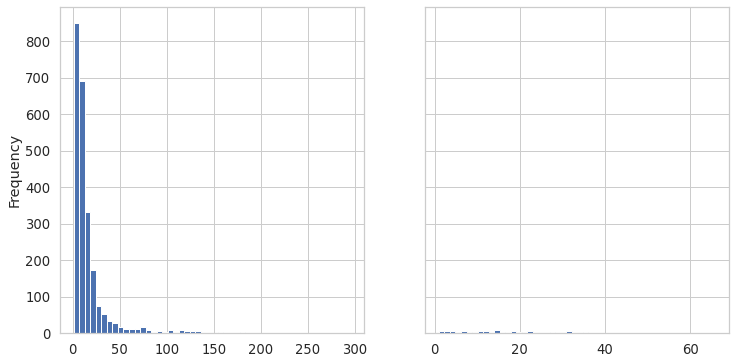

In [49]:
# distribution of number of concepts per person 
sns.set(style='whitegrid',rc={'figure.figsize':(12,6)}, font_scale=1.2)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
concepts_df.groupby('grid').count()['type'].plot.hist(bins=50, ax=ax1)

# distribution of  number of unique concepts per person
before_28wks_df.groupby(['grid','ne']).count().reset_index().groupby('grid').count()['ne'].plot.hist(bins=50, ax = ax2)

# Feature Selection 

In [50]:
# check for any missing values in 'ne' column
before_28wks_df[before_28wks_df['ne'].isnull()]

,grid,type,pos_in_txt1,pos_in_txt2,assertion,semantic,cui,ne,delivery_label,delivery_date,row_num,date,days_diff,preg_start,days_in_preg


## CUIs

In [63]:
cui_feat_df = wide_cui_df.loc[:, selected_cui_df.cui].copy()
cui_feat_df.reset_index(inplace=True)

In [71]:
#write 
# cui_feat_file = os.path.join(root_path, "/abraha1/projects/PTB_phenotyping/data/ptb_predict_machine_learning/feature_matrices/ob_notes_unstruct", "filtered_cui_counts_ob_notes_feat_mat.tsv")
cui_feat_file = os.path.join(FEAT_OUTPUT_DIR, "filtered_cui_counts_ob_notes_since_concep_up_to_28wk_feat_mat.tsv")
# cui_feat_df.to_csv(cui_feat_file, sep="\t", index=False)

## Concepts

### clean up concepts (upper/lower case)

In [72]:
before_28wks_df.head()

,grid,type,pos_in_txt1,pos_in_txt2,assertion,semantic,cui,ne,delivery_label,delivery_date,row_num,date,days_diff,preg_start,days_in_preg
1558,R200063476,NamedEntity,46,49,present,problem,None,AMA,term,2016-11-12,0,2016-03-30,-227 days,2016-02-02,57 days
1559,R200063476,NamedEntity,467,476,present,problem,None,Pregnancy,term,2016-11-12,12,2016-03-30,-227 days,2016-02-02,57 days
1560,R200063476,NamedEntity,637,651,present,test,C2963416,Prenatal panel,term,2016-11-12,18,2016-03-30,-227 days,2016-02-02,57 days
1561,R200063476,NamedEntity,670,684,present,test,C1610733,Urine specimen,term,2016-11-12,19,2016-03-30,-227 days,2016-02-02,57 days
1562,R200063476,NamedEntity,699,704,present,test,C1858668,GC/CT,term,2016-11-12,19,2016-03-30,-227 days,2016-02-02,57 days


In [73]:
lower_cols = [x.lower() for x in before_28wks_df['ne'].unique()]
col_df = pd.DataFrame({'COLNAME':before_28wks_df['ne'].unique(), 'colname':lower_cols})

In [74]:
def create_set(x):
    return set(x.COLNAME.values)

In [75]:
col_df.groupby('colname').apply(lambda x : create_set(x) ).reset_index().rename(columns={0:''})

,colname,
0,1hgct,{1hGCT}
1,1st tri us,"{1st tri US, 1st tri Us}"
2,1st trimester changes,{1st trimester changes}
3,2+ pedal edema,{2+ Pedal edema}
4,24 hr,{24 hr}
...,...,...
1024,wt smear,{Wt smear}
1025,yeast,"{yeast, Yeast}"
1026,yeast infection,{yeast infection}
1027,zika,{zika}


### create feature matrix

In [76]:
long_counts_df = concepts_df.groupby(['grid','ne']).size().reset_index().rename(columns={0:'counts'})
raw_matrix_df = long_counts_df.pivot(index='grid',columns='ne', values='counts').fillna(0)

In [77]:
# create frequency of hits for each features
concept_counts = raw_matrix_df.sum(0).sort_values(ascending=False).reset_index().rename(columns={0:'count'})
concept_counts.head()

,ne,count
0,Contraception,1647.0
1,contraception,985.0
2,annual,667.0
3,detailed exam,666.0
4,US,611.0


### Remove features with low frequency 

In [78]:
# retain only feature that have freq > 1% of number of grids 
freq_thresh  = raw_matrix_df.shape[0] * 0.5/100
print("Min number of counts requried: {}".format(freq_thresh))
feat_to_retain = concept_counts.loc[concept_counts['count'] > freq_thresh, 'ne'].values
feat_mat_df = raw_matrix_df.loc[:, feat_to_retain].reset_index()

Min number of counts requried: 11.965


In [79]:
# add delivery labels
feat_mat_df['label'] = feat_mat_df.grid.map(final_labels_dict)

In [80]:
feat_mat_df.head(3)
feat_mat_df.shape

ne,grid,Contraception,contraception,annual,detailed exam,US,GBS,PE,DMS,Pap,...,Gestational hypertension,Urine specimen,protection,uterine rupture,Vaginal bleeding,wt gain,TWG,acne,redness,label
0,R200006865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,term
1,R200009152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,postterm
2,R200009182,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,term


(2393, 464)

In [81]:
feat_mat_df.shape

(2393, 464)

### write feat matrix

In [82]:
feat_mat_df.head()
feat_file = os.path.join(FEAT_OUTPUT_DIR, "all_nlp_concepts_counts_ob_notes_since_concep_up_to_28wk_feat_mat.tsv")
feat_mat_df.rename(columns={'grid':'GRID'}, inplace=True)
feat_mat_df.drop('label',axis=1).to_csv(feat_file, sep="\t", index=False)

ne,grid,Contraception,contraception,annual,detailed exam,US,GBS,PE,DMS,Pap,...,Gestational hypertension,Urine specimen,protection,uterine rupture,Vaginal bleeding,wt gain,TWG,acne,redness,label
0,R200006865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,term
1,R200009152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,postterm
2,R200009182,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,term
3,R200020899,1.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,term
4,R200021053,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,preterm


In [83]:
FEAT_OUTPUT_DIR

'/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/data/ptb_predict_machine_learning/feature_matrices/ob_notes_unstruct/since_concep_upto_28_weeks'